<a href="https://colab.research.google.com/github/kjxeez/machine-learning/blob/main/Poly_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра информационных технологий 

## ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ № 2


### Дисциплина: Методы машинного обучения

##### Студент:  Акопян Изабелла Арменовна
##### Группа:   НБИ-01-20

## Москва 2023
***

### Вариант № 11

Лабораторная работа 2 – Вариант 11 

1. Набор данных: forest_fires 

2. Независимая переменная: features/FFMC 

3. Зависимая переменная: features/DMC 

4. Доп. признак: имеющий максимальную дисперсию 

5. Визуализация доп. признака – столбчатая диаграмма 

6. Показатель качества регрессии – MAE (mean absolute error) 

7. Степень полинома: 4 

8. Параметры глубокой нейронной сети: кол-во скрытых слоев – 4, кол-во нейронов в скрытом слое – 64, функция активации – сигмоида. 

В соответствии с индивидуальным заданием, указанным в записной книжке команды, выполните следующие работы:  

1. Загрузите заданный в индивидуальном задании набор данных из Tensorflow Datasets, включая указанные в задании независимый признак и зависимый признак (отклик). 

2. Решите задачу полиномиальной регрессии для степени полинома, указанной в индивидуальном задании, при помощи нейронной сети с одним нейроном и оцените качество полученной модели по показателю, указанному в индивидуальном задании.  
3. Постройте кривые обучения с зависимостью от количества эпох. 
4. Визуализируйте точки набора данных на плоскости в виде диаграммы рассеяния (ось X – независимый признак, ось Y – зависимый признак), а также линию регрессии (другим цветом), подписывая оси и рисунок.  
5. Определите в исходном наборе данных признак (отличный от независимого и зависимого признаков), принимающий непрерывные значения и имеющий свойства, указанные в индивидуальном задании.  
6. Визуализируйте этот признак в соответствии с индивидуальным заданием.  
7. Сформируйте набор входных данных из двух признаков набора данных (независимый признак и определенный признак), создайте и адаптируйте нормализующий слой Tensorflow для двух признаков.  
8. Используя созданный нормализующий слой, постройте нейронную сеть (нелинейный регресор) с количеством скрытых слоев, количеством нейронов и функцией активации, указанными в индивидуальном задании, и одним нейроном в выходном слое и обучите ее на наборе данных из двух признаков и отклика.  
9. Визуализируйте набор данных в виде точечного графика и прогноз нейронной сети в виде поверхности в трехмерном пространстве. 
10. Разбейте набор данных из двух признаков и отклика на обучающую и тестовую выборки и постройте кривые обучения для заданного показателя качества в зависимости от количества точек в обучающей выборке, подписывая оси и рисунок и создавая легенду. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import tensorflow_datasets as tfds

Загрузите заданный в индивидуальном задании набор данных из Tensorflow Datasets, включая указанные в задании независимый признак и зависимый признак (отклик).



In [2]:
ds = tfds.load("forest_fires", split='train')
df = tfds.as_dataframe(ds)
df

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/forest_fires/0.0.1.incompleteSG9HZV/forest_fires-train.tfrecord*...:   0%|…

Dataset forest_fires downloaded and prepared to /root/tensorflow_datasets/forest_fires/0.0.1. Subsequent calls will reuse this data.


,area,features/DC,features/DMC,features/FFMC,features/ISI,features/RH,features/X,features/Y,features/day,features/month,features/rain,features/temp,features/wind
0,10.820000,671.200012,181.100006,96.099998,14.300000,63.000000,7,5,1,7,6.400000,27.299999,4.900000
1,24.590000,750.500000,96.699997,90.500000,11.400000,55.000000,3,4,6,8,0.000000,20.600000,5.400000
2,0.170000,607.099976,131.699997,94.300003,22.700001,55.000000,6,5,1,7,0.000000,19.400000,4.000000
3,14.680000,671.200012,181.100006,96.099998,14.300000,27.000000,3,4,1,7,0.000000,32.299999,2.200000
4,88.489998,699.599976,133.300003,92.900002,9.200000,21.000000,4,4,2,8,0.000000,26.400000,4.500000
5,5.180000,714.299988,84.099998,89.599998,5.700000,35.000000,3,4,6,8,0.000000,23.799999,3.600000
6,9.960000,855.299988,290.000000,90.300003,7.400000,58.000000,2,5,4,8,0.000000,16.200001,3.600000
7,2.070000,596.299988,135.500000,95.000000,21.299999,28.000000,2,4,0,7,0.000000,30.600000,3.600000
8,5.970000,745.299988,99.000000,92.099998,9.600000,50.000000,7,4,4,8,0.000000,18.700001,2.200000
9,0.750000,503.600006,91.599998,92.199997,9.600000,70.000000,2,4,2,7,0.000000,20.700001,2.200000


Решите задачу полиномиальной регрессии для степени полинома, указанной в индивидуальном задании, при помощи нейронной сети с одним нейроном и оцените качество полученной модели по показателю, указанному в индивидуальном задании.

Независимая переменная: features/FFMC

Зависимая переменная: features/DMC

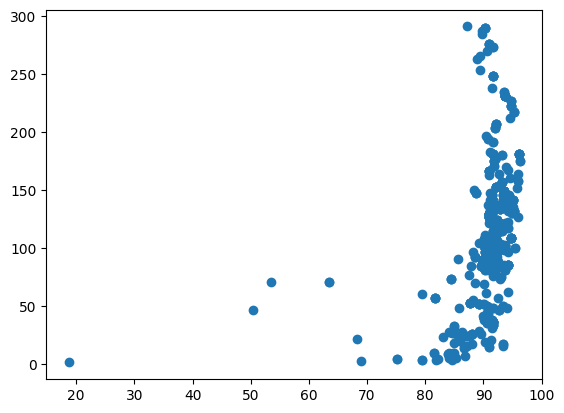

In [3]:

x = np.array(df['features/FFMC']) # вектор
y =  np.array(df['features/DMC'])
m=len(y)
X = x.reshape(-1, 1)  
plt.scatter(x, y);
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [4]:
#1 способ
X2 = np.hstack([X, X**2]) # соединение массивов по горизонтали
X2.shape


(517, 2)

In [5]:
def J(x_):
    return (x_-2.5)**2 - 1.

def dJ(x_):
    return 2*(x_-2.5)

In [6]:
def gradient_descent(initial_x, eta, n_iters = 1e4, epsilon=1e-8):
    x_ = initial_x
    x_history = [initial_x]
    i_iter = 0

    while i_iter < n_iters:
        gradient = dJ(x_)
        last_x_ = x_
        x_ -= eta * gradient
        x_history.append(x_)
    
        if(abs(J(x_) - J(last_x_)) < epsilon):
            break
        i_iter += 1
        
    return x_history
            
def plot_history(plot_x, x_history):
    plt.plot(plot_x, J(plot_x))
    plt.plot(np.array(x_history), J(np.array(x_history)), color="r", marker='+')
    plt.text(1., 10., f'Кол-во шагов: {len(x_history)}', fontsize=14, color='r')

In [7]:
class RegressionSGD:

    def __init__(self):
        self.coef_ = None
        self.intercept_ = None
        self._theta = None

    def fit(self, X_train, y_train, n_iters=50, t0=5, t1=50):
        assert X_train.shape[0] == y_train.shape[0], \
            "Размер X_train должен быть равен размеру y_train"
        assert n_iters >= 1

        def dJ_sgd(theta, X_b_i, y_i):
            return X_b_i * (X_b_i.dot(theta) - y_i) * 2.

        def sgd(X_b, y, initial_theta, n_iters=5, t0=5, t1=50):

            def learning_rate(t):
                return t0 / (t + t1)

            theta = initial_theta
            m = len(X_b)
            for i_iter in range(n_iters):
                indexes = np.random.permutation(m)
                X_b_new = X_b[indexes,:]
                y_new = y[indexes]
                for i in range(m):
                    gradient = dJ_sgd(theta, X_b_new[i], y_new[i])
                    theta = theta - learning_rate(i_iter * m + i) * gradient

            return theta

        X_b = np.hstack([np.ones((len(X_train), 1)), X_train])
        initial_theta = np.random.randn(X_b.shape[1])
        self._theta = sgd(X_b, y_train, initial_theta, n_iters, t0, t1)

        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]

        return self

    def predict(self, X_predict):
        assert self.intercept_ is not None and self.coef_ is not None, \
            "Нужно обучить модель перед использованием!"
        assert X_predict.shape[1] == len(self.coef_), \
            "Кол-во признаков в X_predict должно быть равно кол-ву признаков в X_train"

        X_b = np.hstack([np.ones((len(X_predict), 1)), X_predict])
        return X_b.dot(self._theta)

    def score(self, X_test, y_test):
        y_predict = self.predict(X_test)
        return r2_score(y_test, y_predict)

    def __repr__(self):
        return "RegressionSGD()"

In [8]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [33]:
x_train,x_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=42)

In [34]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=4) 
X_train = poly.fit_transform(pd.DataFrame(x_train).values.reshape(-1, 1))
X_test = poly.transform(pd.DataFrame(x_test).values.reshape(-1, 1))
X_test

array([[ 1.0000000e+00, -1.0960897e+00,  1.2014127e+00, -1.3168561e+00,
         1.4433925e+00],
       [ 1.0000000e+00,  4.6297677e-02,  2.1434750e-03,  9.9237914e-05,
         4.5944848e-06],
       [ 1.0000000e+00,  8.2602113e-01,  6.8231094e-01,  5.6360328e-01,
         4.6554822e-01],
       [ 1.0000000e+00,  4.9962577e-01,  2.4962591e-01,  1.2471954e-01,
         6.2313095e-02],
       [ 1.0000000e+00,  6.4430527e-02,  4.1512931e-03,  2.6746999e-04,
         1.7233233e-05],
       [ 1.0000000e+00,  1.3696329e-01,  1.8758943e-02,  2.5692866e-03,
         3.5189796e-04],
       [ 1.0000000e+00,  5.1775861e-01,  2.6807398e-01,  1.3879761e-01,
         7.1863659e-02],
       [ 1.0000000e+00,  1.3696329e-01,  1.8758943e-02,  2.5692866e-03,
         3.5189796e-04],
       [ 1.0000000e+00,  4.4522583e-01,  1.9822605e-01,  8.8255361e-02,
         3.9293565e-02],
       [ 1.0000000e+00,  8.0788833e-01,  6.5268356e-01,  5.2729541e-01,
         4.2599580e-01],
       [ 1.0000000e+00, -3.163

In [35]:
reg2_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1,input_dim=X_train.shape[1], activation='sigmoid')
])

In [36]:
reg2_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [37]:
reg2_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [38]:
history = reg2_model.fit(
    X_train, y_train, 
    epochs=100,
    # уровень выводимой информации
    verbose=0,
    # проверка (валидация) на 30% обучающих данных
    validation_data=(X_test, y_test))

Постройте кривые обучения с зависимостью от количества эпох.



In [39]:
y_test_pred = reg2_model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
print('Test MAE:', mae_test)

5/5 [==============================] - 0s 2ms/step
Test MAE: 111.54047


In [40]:
def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Функция потерь при обучении модели')
  plt.xlabel('Эпохи обучения')
  plt.ylabel('Функция потерь')
  plt.legend(['Обучающая выборка', 'Тестовая выборка'], loc='upper right')
  plt.grid(True)

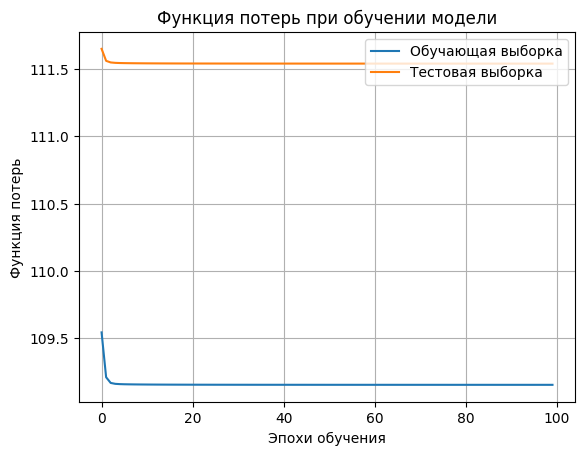

In [41]:
plot_loss(history)

Визуализируйте точки набора данных на плоскости в виде диаграммы рассеяния (ось X – независимый признак, ось Y – зависимый признак), а также линию регрессии (другим цветом), подписывая оси и рисунок.

12/12 [==============================] - 0s 3ms/step


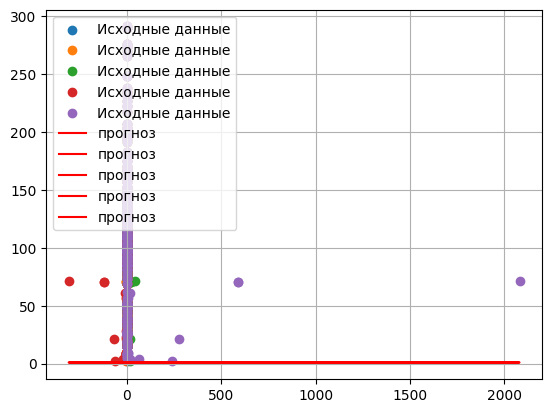

In [45]:
y_predict_uni = reg2_model.predict(X_train)
fig, ax = plt.subplots()
ax.scatter(X_train[:, 0], y_train, label='Исходные данные')
ax.scatter(X_train[:, 1], y_train, label='Исходные данные')
ax.scatter(X_train[:, 2], y_train, label='Исходные данные')
ax.scatter(X_train[:, 3], y_train, label='Исходные данные')
ax.scatter(X_train[:, 4], y_train, label='Исходные данные')
ax.plot(np.sort(X_train), y_predict_uni, color='r', label='прогноз')
plt.legend(loc='upper left')
plt.grid();

Определите в исходном наборе данных признак (отличный от независимого и зависимого признаков), принимающий непрерывные значения и имеющий свойства, указанные в индивидуальном задании.

In [46]:
variances = df.var()
max_variance = variances.max()
print("Variances: ")
print(variances)
print("Max variance:", max_variance)

Variances: 
area               4052.063232
features/DC       61536.835938
features/DMC       4101.951660
features/FFMC        30.471624
features/ISI         20.788832
features/RH         266.259796
features/X            5.353568
features/Y            1.512655
features/day          4.297033
features/month        5.180131
features/rain         0.087592
features/temp        33.716896
features/wind         3.210019
dtype: float64
Max variance: 61536.8359375


признак с наибольшей дисперсией - features/DC       61536.835938

Визуализируйте этот признак в соответствии с индивидуальным заданием.

Визуализация доп. признака – столбчатая диаграмма

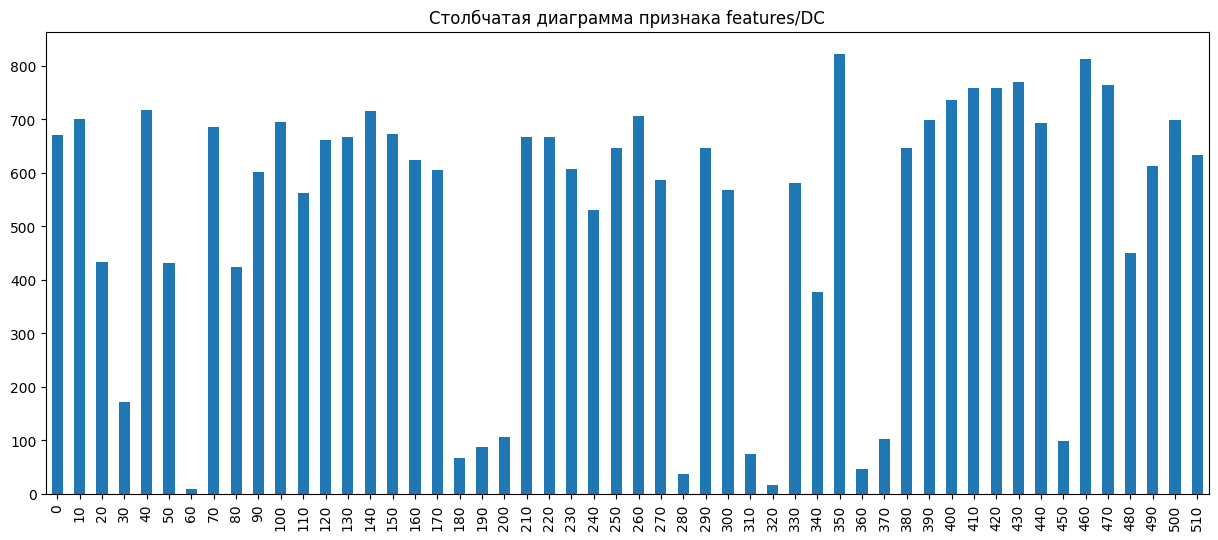

In [49]:
df[::10]['features/DC'].plot.bar(title='Столбчатая диаграмма признака features/DC', figsize=(15,6));

Сформируйте набор входных данных из двух признаков набора данных (независимый признак и определенный признак), создайте и адаптируйте нормализующий слой Tensorflow для двух признаков.

In [50]:
X = df[['features/FFMC', 'features/DC']]
y = df['features/DMC']
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=42)

In [53]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((361, 2), (156, 2), (361,), (156,))

In [51]:
# Создание и адаптация нормализующего слоя
normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
normalizer.adapt(X_train)

Используя созданный нормализующий слой, постройте нейронную сеть (нелинейный регресор) с количеством скрытых слоев, количеством нейронов и функцией активации, указанными в индивидуальном задании, и одним нейроном в выходном слое и обучите ее на наборе данных из двух признаков и отклика.

In [54]:
# кол-во скрытых слоев – 4, кол-во нейронов в скрытом слое – 64, функция активации – relu.
# Создание нейронной сети
model = tf.keras.models.Sequential([
    normalizer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Компиляция модели
model.compile(loss='mse', optimizer='adam')

# Обучение модели

train_score = []
test_score = []
history=[]
for i in range(11, 3428, 500):
    history.append(model.fit(X_train, y_train, epochs=100, validation_data=(X_test,y_test)))
    y_train_predict = model.predict(X_train[:i])
    train_score.append(mean_absolute_error(y_train[:i], y_train_predict))
    y_test_predict = model.predict(X_test)
    test_score.append(mean_absolute_error(y_test, y_test_predict))
    print('-->', i, ' done')

Epoch 1/100
12/12 [==============================] - 1s 21ms/step - loss: 16151.7559 - val_loss: 16763.3008
Epoch 2/100
12/12 [==============================] - 0s 7ms/step - loss: 16030.9434 - val_loss: 16554.9277
Epoch 3/100
12/12 [==============================] - 0s 7ms/step - loss: 15686.6484 - val_loss: 15946.6982
Epoch 4/100
12/12 [==============================] - 0s 6ms/step - loss: 14666.9990 - val_loss: 14271.9580
Epoch 5/100
12/12 [==============================] - 0s 8ms/step - loss: 12139.3076 - val_loss: 10675.5957
Epoch 6/100
12/12 [==============================] - 0s 8ms/step - loss: 7393.0493 - val_loss: 5610.4390
Epoch 7/100
12/12 [==============================] - 0s 8ms/step - loss: 3195.1011 - val_loss: 4023.8411
Epoch 8/100
12/12 [==============================] - 0s 6ms/step - loss: 2639.2014 - val_loss: 2632.3518
Epoch 9/100
12/12 [==============================] - 0s 6ms/step - loss: 2372.3169 - val_loss: 2453.1919
Epoch 10/100
12/12 [========================

Визуализируйте набор данных в виде точечного графика и прогноз нейронной сети в виде поверхности в трехмерном пространстве.

313/313 [==============================] - 1s 2ms/step


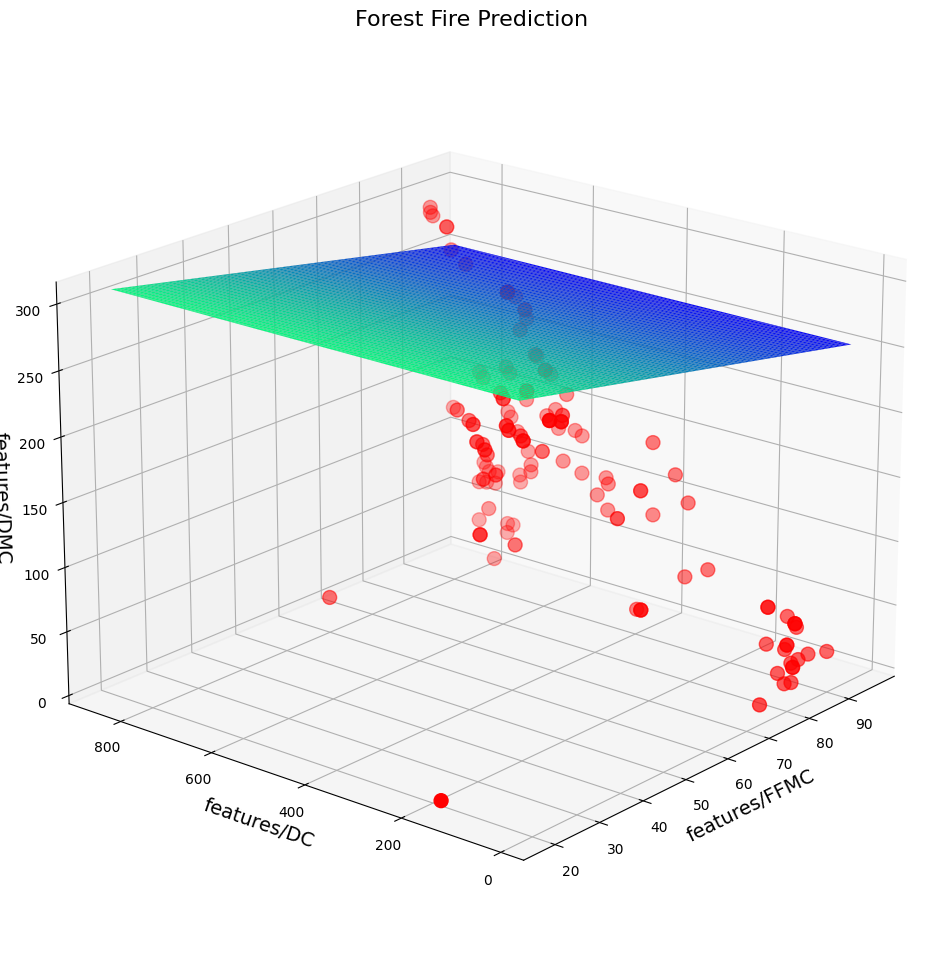

In [59]:
from matplotlib import cm
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

# Построение поверхности
x_mesh, y_mesh = np.meshgrid(np.linspace(X_test['features/FFMC'].min(), X_test['features/FFMC'].max(), 100), \
                             np.linspace(X_test['features/DC'].min(), X_test['features/DC'].max(), 100))
z_mesh = model.predict(normalizer(np.c_[x_mesh.ravel(), y_mesh.ravel()])).reshape(x_mesh.shape)

surf = ax.plot_surface(x_mesh, y_mesh, z_mesh, rstride=1, cstride=1, linewidth=0.05, cmap=cm.winter, antialiased=True,edgecolors='gray') 

# Построение точечного графика
xs = X_test['features/FFMC']
ys = X_test['features/DC']
zs = y_test
ax.scatter( xs, ys, zs, s=100, c='r' )

# Настройка осей и заголовка
ax.set_xlabel('features/FFMC', fontsize=14) 
ax.set_ylabel('features/DC', fontsize=14)
ax.set_zlabel('features/DMC', fontsize=14) 
ax.set_title('Forest Fire Prediction', fontsize=16)

# Настройка ограничений по оси z
ax.set_zlim(0., z_mesh.max())

# Настройка точки обзора
ax.view_init(elev = 20, azim = 220)

plt.show()

Разбейте набор данных из двух признаков и отклика на обучающую и тестовую выборки и постройте кривые обучения для заданного показателя качества в зависимости от количества точек в обучающей выборке, подписывая оси и рисунок и создавая легенду.

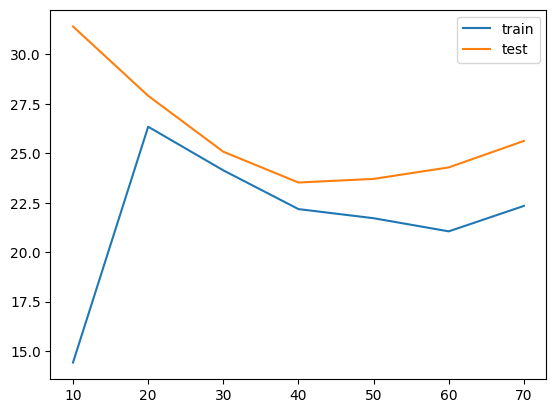

In [57]:
plt.plot([i for i in range(10, 71, 10)], 
         train_score, label="train")
plt.plot([i for i in range(10, 71, 10)], 
         test_score, label="test")
plt.legend()
